In [34]:
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
from collections import defaultdict
import os
from torch.utils import data
import matplotlib.pyplot as plt
import pandas as pd
from sys import platform

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cpu")
OUTPUT_DIR_TRAIN='data/train.dat'
OUTPUT_DIR_TEST='data/test1.dat'

NUM_RESTS = 5138
NUM_USERS = 3579

In [35]:
def get_sparse_mat(filename):
  
    '''
    
    Inputs: 
        -filename: a string containing the name of the file from which we want
                    to extract the data. In our case it can be either train.dat
                    or test.dat
                    
    Returns a python list of size 3579 (number of users) with each element of
    the list being a list of tuples (restaurantID, rating).
    
    '''
    
    sparse_mat = []
    
    # YOUR CODE HERE
    df=pd.read_csv(filename, names=['userID','restID','rating'],header=None)
    df['tuple'] = list(zip(df.restID, df.rating))
    keys, values = df[['userID','tuple']].to_numpy().T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values, index[1:])
    df2 = pd.DataFrame({'a':ukeys, 'b':[list(a) for a in arrays]})
    return df2.b.tolist()

In [36]:
#Now that we have implemented the get_sparse_mat function we can get the train and test sparse matrices
train_smat = get_sparse_mat(OUTPUT_DIR_TRAIN)
test_smat = get_sparse_mat(OUTPUT_DIR_TEST)

In [37]:
class Dataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        X_sam = torch.zeros(5138)
        y_sam = torch.zeros(5138)
        for i in range(len(self.X[index])):
            X_sam[self.X[index][i][0]] = self.X[index][i][1]

        for i in range(len(self.y[index])):
            y_sam[self.y[index][i][0]] = self.y[index][i][1]

        return X_sam, y_sam

In [38]:
train_dataset = Dataset(train_smat,train_smat)
test_dataset = Dataset(train_smat, test_smat)

In [39]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6 if platform == 'linux' else 0}
training_generator = data.DataLoader(train_dataset, **params)# sampler = torch.utils.data.SequentialSampler(train_dataset))
validation_generator = data.DataLoader(test_dataset, **params)# sampler = torch.utils.data.SequentialSampler(train_dataset))

In [40]:
class DAE(nn.Module):
    def __init__(self):
        '''
        Define the layers and activation functions to be used in the network.
        '''
        super(DAE,self).__init__()
        
        # YOUR CODE HERE
        self.layer1=nn.Linear(5138,128)
        self.layer2=nn.Linear(128,40)
        self.layer3=nn.Linear(40,20)
        self.layer4=nn.Linear(20,32)
        self.layer5=nn.Linear(32,5138)
        self.relu = nn.ReLU()
        self.tanh=nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.selu=nn.SELU()
        self.dropout=nn.Dropout(0.3)
        
        #raise NotImplementedError()
        
    def forward(self, x):
        '''
        Implement the forward function which takes as input the tensor x and feeds it to the layers of the network
        and returns the output.
        
        Inputs:
            -x : Input tensor of shape [N_batch, 5138]
            
        Returns the output of neural network of shape [N_batch, 5138]
        '''
        
        out = torch.zeros(x.shape[0], 5138)
        
        # YOUR CODE HERE
        outtemp=self.layer1(x)
        outtemp=self.relu(outtemp)
        outtemp=self.dropout(outtemp)
        outtemp=self.layer2(outtemp)
        outtemp=self.sigmoid(outtemp)
        outtemp=self.layer3(outtemp)
        outtemp=self.tanh(outtemp)
        outtemp=self.layer4(outtemp)
        outtemp=self.relu(outtemp)
        out=self.layer5(outtemp)
        #raise NotImplementedError()
        return out

In [41]:
net = DAE()

In [42]:
def masked_loss(preds, labels):
    
    '''
    Inputs:
        -preds: Model predictions [N_batch, 5138]
        -labels: User ratings [N_batch, 5138]
        
    Returns the masked loss as described above.
    '''
    
    loss = 0
    
    # YOUR CODE HERE
    masked_pred = torch.where(labels!=0, preds, labels)
    masked_diff = masked_pred - labels
    loss = torch.sum(torch.mul(masked_diff, masked_diff))/np.count_nonzero(labels.data.numpy())
    #raise NotImplementedError()
    
    return loss

In [43]:
def train(net, criterion, opti, training_generator, validation_generator, max_epochs = 10):
    
    '''
    Inputs:
        - net: The model instance
        - criterion: Loss function, in our case it is masked_loss function.
        - opti: Optimizer Instance
        - training_generator: For iterating through the training set
        - validation_generator: For iterating through the test set
        - max_epochs: Number of training epochs. One epoch is defined as one complete presentation of the data set.
    
    Outputs:
        - train_losses: a list of size max_epochs containing the average loss for each epoch of training set.
        - val_losses: a list of size max_epochs containing the average loss for each epoch of test set.
        
        Note: We compute the average loss in an epoch by summing the loss at each iteration of that epoch
        and then dividing the sum by the number of iterations in that epoch.
    '''

    train_losses = []
    val_losses = []
    
    for epoch in range(max_epochs):
        running_loss = 0 #Accumulate the loss in each iteration of the epoch in this variable
        cnt = 0 #Increment it each time to find the number iterations in the epoch.
        # Training iterations
        for batch_X, batch_y in training_generator:
            opti.zero_grad() #Clears the gradients of all variables.
            
            # YOUR CODE HERE
            outputs = net(batch_X)
            loss = criterion(outputs,batch_y)
            running_loss = running_loss + loss.item()
            loss.backward()
            opti.step()
            cnt = cnt + 1
            #raise NotImplementedError()

        print("Epoch {}: Training Loss {}".format(epoch+1, running_loss/cnt))
        train_losses.append(running_loss/cnt)
        
        
        #Now that we have trained the model for an epoch, we evaluate it on the test set
        net = net.eval()
        running_loss = 0
        cnt = 0
        with torch.set_grad_enabled(False):
            for batch_X, batch_y in validation_generator:

                # YOUR CODE HERE
                outputs= net (batch_X)
                loss = criterion(outputs,batch_y)
                running_loss = running_loss + loss.item()
                cnt = cnt + 1
                #raise NotImplementedError()
                
        print("Epoch {}: Validation Loss {}".format(epoch+1, running_loss/cnt))

        val_losses.append(running_loss/cnt)
        net = net.train()
        
    return train_losses, val_losses

In [44]:
net = DAE()
opti = optim.Adam(net.parameters(), lr = 0.0005, weight_decay=1e-5)
train_losses, val_losses = train(net, masked_loss, opti, training_generator, validation_generator, 37)

Epoch 1: Training Loss 15.453087312834603
Epoch 1: Validation Loss 13.713452901159014
Epoch 2: Training Loss 10.202275225094386
Epoch 2: Validation Loss 6.208438737051828
Epoch 3: Training Loss 3.6721310700689043
Epoch 3: Validation Loss 2.2183612989527837
Epoch 4: Training Loss 1.5011006402117866
Epoch 4: Validation Loss 1.312226147523948
Epoch 5: Training Loss 0.9727319351264408
Epoch 5: Validation Loss 1.0278979103480066
Epoch 6: Training Loss 0.7903412261179515
Epoch 6: Validation Loss 0.9069296983735902
Epoch 7: Training Loss 0.7102576174906322
Epoch 7: Validation Loss 0.8418584423405784
Epoch 8: Training Loss 0.6693575999566487
Epoch 8: Validation Loss 0.8046332374215126
Epoch 9: Training Loss 0.6454342092786517
Epoch 9: Validation Loss 0.7810995536191123
Epoch 10: Training Loss 0.6321254212941442
Epoch 10: Validation Loss 0.7667135064091001
Epoch 11: Training Loss 0.6218099104506629
Epoch 11: Validation Loss 0.7543469667434692
Epoch 12: Training Loss 0.6146286044801984
Epoch 12:

Text(0.5, 0, 'Epochs')

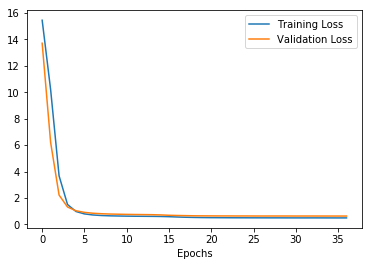

In [45]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')

In [46]:
x, y = test_dataset.__getitem__(4)
net = net.eval()
pred = net(x)
print("Predicted Ratings: ", pred[y!=0].detach().numpy())
print("Actual Ratings: ", y[y!=0].numpy())

Predicted Ratings:  [3.858344  3.70765   3.3733604 4.0613813 4.1819644]
Actual Ratings:  [3.5 3.5 4.  4.  4. ]


In [47]:
def get_predictions(net, train_data = train_smat):
    
    def get_test_smat(filename = 'data/test_hidden.dat'):
        sparse_dict = defaultdict(list)
        for line in open(filename):
            splitted_line = line.split(',')
            sparse_dict[int(splitted_line[0])].append((int(splitted_line[1])))

        sparse_mat = []
        sKeys = sorted(sparse_dict)
        for key in sKeys:
            sparse_mat.append(sparse_dict[key])
        
        return sparse_mat
            
            
    test_smat = get_test_smat()
    preds = []
    for i in range(len(train_data)):
        
        #Getting the actual vector from the sparse representation
        x = torch.zeros(5138)
        for j in range(len(train_data[i])):
            x[train_data[i][j][0]] = train_data[i][j][1]
        with torch.set_grad_enabled(False):
            pred = net(x).detach().numpy() ## This logic might be different for your model, change this accordingly
        
        pred = pred[test_smat[i]]
        user_rest_pred = np.concatenate([i*np.ones((len(pred),1),dtype=np.int),np.array(test_smat[i],dtype=np.int)[:,None], np.array(pred)[:,None]],axis = 1)
        preds += user_rest_pred.tolist()
        
    preds = np.array(preds)
    df = pd.DataFrame(preds)
    df[0] = df[0].astype('int')
    df[1] = df[1].astype('int')
    df[2] = df[2].astype('float16')
    df = df.drop(df.columns[[0, 1]], axis=1)
    df['index1'] = df.index.values
    df.columns = ['rating', 'id']
    df = df[['id','rating']]
    df.to_csv('predictions.csv', index=False, header=True)    
    return df

In [48]:
df = get_predictions(net)
df.head()

,id,rating
0,0,4.437500
1,1,3.876953
2,2,3.970703
3,3,4.519531
4,4,4.281250
